In [119]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from matplotlib import cm
import time
from numpy.random import default_rng

import healpy as hp
import pymaster as nmt
import pandas as pd

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

In [2]:
l = np.arange(-180,180,1)
b = np.arange(-90,90,1)
l_grid, b_grid = np.meshgrid(l, b)
c = SkyCoord(l=l_grid*u.degree, b=b_grid*u.degree, frame='galactic')
l_arr = l_grid.flatten()
b_arr = b_grid.flatten()

#the map is in (ra,dec) so we need to convert:
ra = c.icrs.ra.degree.flatten() 
dec = c.icrs.dec.degree.flatten() 

In [3]:
def plot_completeness(l, b, completeness, title=None):
    plt.figure(figsize=(8,6))
    plt.title(title)
    plt.scatter( l, b, c=completeness , vmin=0.8, vmax=1,s=1)
    plt.colorbar(label='completeness')
    plt.xlim(180,-180)
    plt.ylim(-90, 90)
    plt.xlabel('l (degrees)')
    plt.ylabel('b (degrees)')
    plt.show()

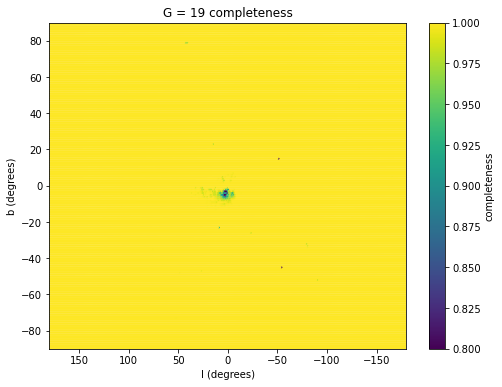

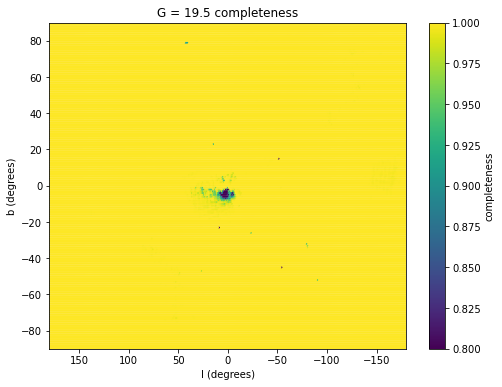

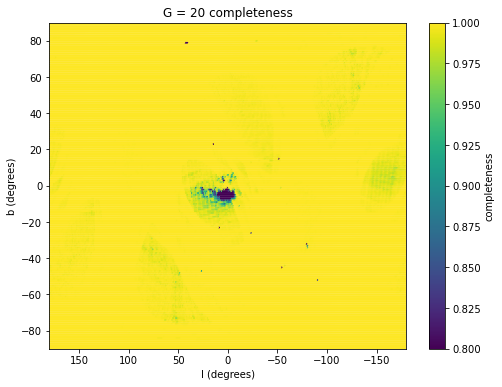

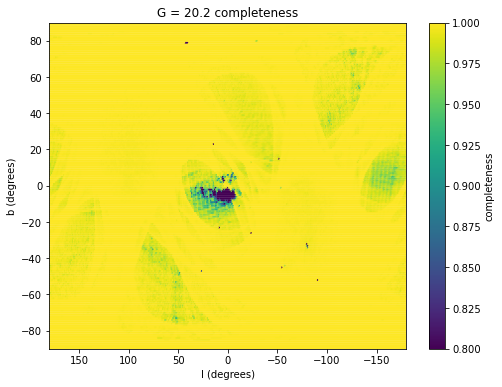

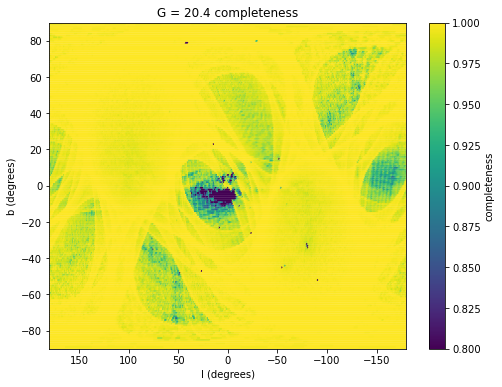

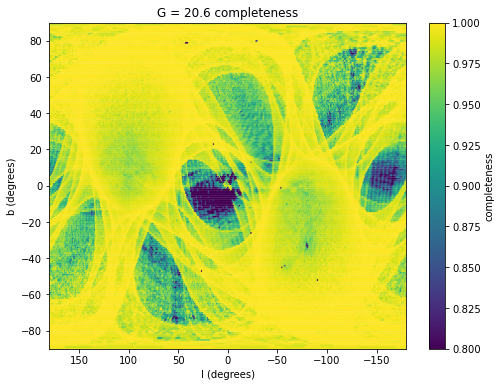

In [4]:
gmag_lims = [19, 19.5, 20, 20.2, 20.4, 20.6]
for gmag in gmag_lims:
    completeness = utils.get_completeness(ra, dec, gmag)
    title = f'G = {gmag} completeness'
    plot_completeness(l_arr, b_arr, completeness, title=title)

## Load in data

In [ ]:
NSIDE = 64
area_per_pixel = hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)

In [23]:
fn_gaia = '../data/gaia_spz_kNN.fits'
tab_gaia = utils.load_table(fn_gaia)
N_data = len(tab_gaia)
ra_data, dec_data, gmag_data = tab_gaia['ra'], tab_gaia['dec'], tab_gaia['phot_g_mean_mag']
print(f"Number of data sources: {N_data}")

Number of data sources: 648842


In [24]:
map_nqso_data, pixel_indices_data = utils.get_map(NSIDE, ra_data, dec_data, null_val=0)

0.0 180.0 -180.0 180.0


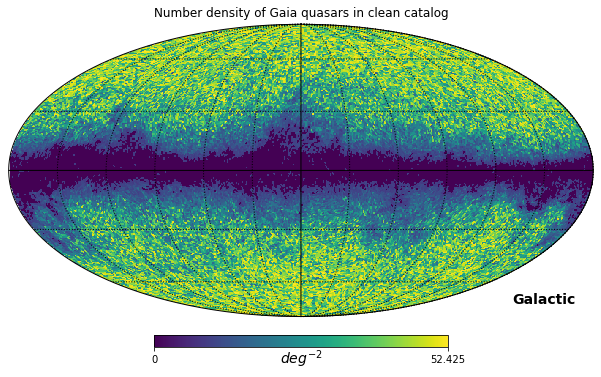

In [25]:
hp.mollview(
    map_nqso_data/area_per_pixel,
    title=rf"Number density of Gaia quasars in clean catalog",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

In [57]:
gmag_min, gmag_max = 19.8, 20
idx_gmaglim = (gmag_min <= gmag_data) & (gmag_data < gmag_max)
ra_data_gmaglim, dec_data_gmaglim = ra_data[idx_gmaglim], dec_data[idx_gmaglim] 
print(len(ra_data_gmaglim), len(ra_data))

138552 648842


In [58]:
map_nqso_data_gmaglim, pixel_indices_data_gmaglim = utils.get_map(NSIDE, ra_data_gmaglim, dec_data_gmaglim, null_val=0)

0.0 180.0 -180.0 180.0


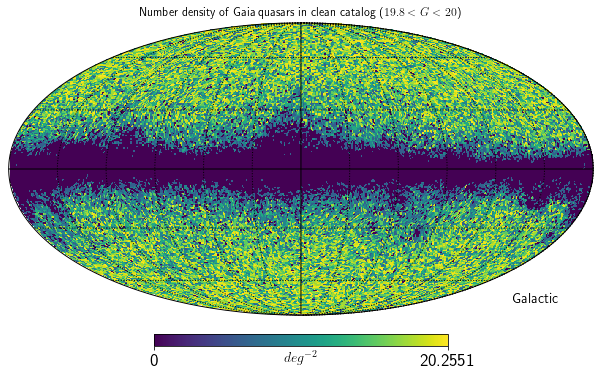

In [60]:
hp.mollview(
    map_nqso_data_gmaglim/area_per_pixel,
    title=rf"Number density of Gaia quasars in clean catalog (${gmag_min} < G < {gmag_max}$)",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

There are basically no sources near the middle where there is low completeness!

### Galactic plane mask:

In [29]:
b_max = 10
mask_func_args = [b_max]
mask_func = masks.galactic_plane_mask
ra_data_plane, dec_data_plane = masks.subsample_by_mask(NSIDE, ra_data, dec_data, mask_func, mask_func_args)

Masked 0.988 of sources


In [30]:
map_nqso_data_plane, pixel_indices_data_plane = utils.get_map(NSIDE, ra_data_plane, dec_data_plane, null_val=0)

0.0 180.0 -180.0 180.0


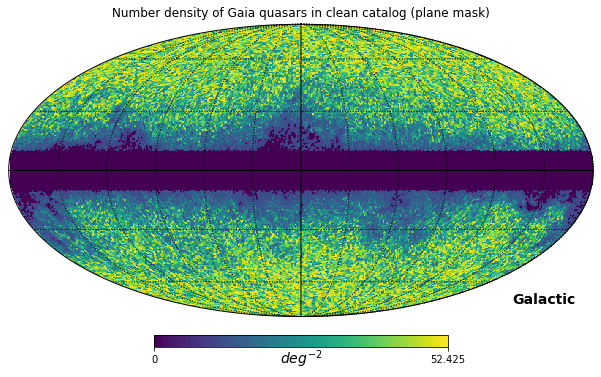

In [31]:
hp.mollview(
    map_nqso_data_plane/area_per_pixel,
    title=rf"Number density of Gaia quasars in clean catalog (plane mask)",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

### Add magellanic cloud mask:

In [94]:
mask_func = masks.magellanic_clouds_mask
mask_func_args = []
ra_data_planemcs, dec_data_planemcs = masks.subsample_by_mask(NSIDE, ra_data_plane, dec_data_plane, 
                                                              mask_func, mask_func_args)

Applied mask; keeping 0.997 of sources


In [95]:
map_nqso_data_planemcs, pixel_indices_data_planemcs = utils.get_map(NSIDE, ra_data_planemcs, dec_data_planemcs, 
                                                                    null_val=0)

0.0 180.0 -180.0 180.0


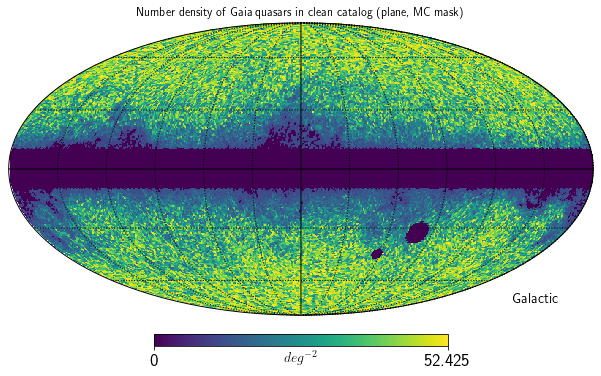

In [129]:
hp.mollview(
    map_nqso_data_planemcs/area_per_pixel,
    title=rf"Number density of Gaia quasars in clean catalog (plane, MC mask)",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

### Add dust mask (Av cut)

In [120]:
rng = default_rng(seed=42)

In [126]:
mask_func = masks.galactic_dust_mask
Av_max = 0.2
map_Av = utils.get_dust_map(NSIDE, rng, R=3.1)
mask_func_args = [Av_max, map_Av]
ra_data_planemcsAv, dec_data_planemcsAv = masks.subsample_by_mask(NSIDE, ra_data_planemcs, dec_data_planemcs, 
                                                              mask_func, mask_func_args)

Masked 0.717 of sources


In [127]:
map_nqso_data_planemcsAv, pixel_indices_data_planemcsAv = utils.get_map(NSIDE, ra_data_planemcsAv, dec_data_planemcsAv, 
                                                                    null_val=0)

0.0 180.0 -180.0 180.0


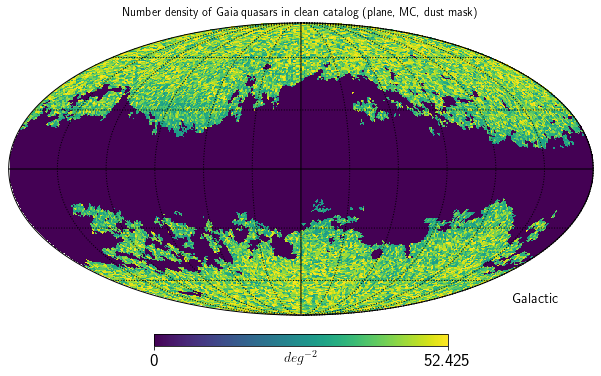

In [128]:
hp.mollview(
    map_nqso_data_planemcsAv/area_per_pixel,
    title=rf"Number density of Gaia quasars in clean catalog (plane, MC, dust mask)",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

## w(theta) random factor test

Test effect of random x factor (on dust, completeness, plane mask version)

In [46]:
nbins = 12
theta_edges_log = np.logspace(-1, 1, nbins + 1)
theta_avg_log = 10**(0.5*(np.log10(theta_edges_log[:-1]) + np.log10(theta_edges_log[1:])))
print(theta_edges_log)

[ 0.1         0.14677993  0.21544347  0.31622777  0.46415888  0.68129207
  1.          1.46779927  2.15443469  3.16227766  4.64158883  6.81292069
 10.        ]


In [50]:
wthetas_plane_facchecks_log = []
facs_rand = [1, 3, 5]
for fac_rand in facs_rand:
    tab_rdustcompplane_facrand = utils.load_table(f'../data/randoms/random_dust_completeness_maskplane_{fac_rand}x.fits')
    wtheta_plane_facchecks_log = correlations.compute_wtheta(theta_edges_log, ra_data_plane, dec_data_plane,
                                                tab_rdustcompplane_facrand['ra'], tab_rdustcompplane_facrand['dec'])
    wthetas_plane_facchecks_log.append(wtheta_plane_facchecks_log)

Time: 6.5194 s
Time: 13.7686 s
Time: 7.2055 s
Time: 7.7178 s
Time: 46.0018 s
Time: 65.0470 s
Time: 7.9475 s
Time: 77.3632 s
Time: 190.1923 s


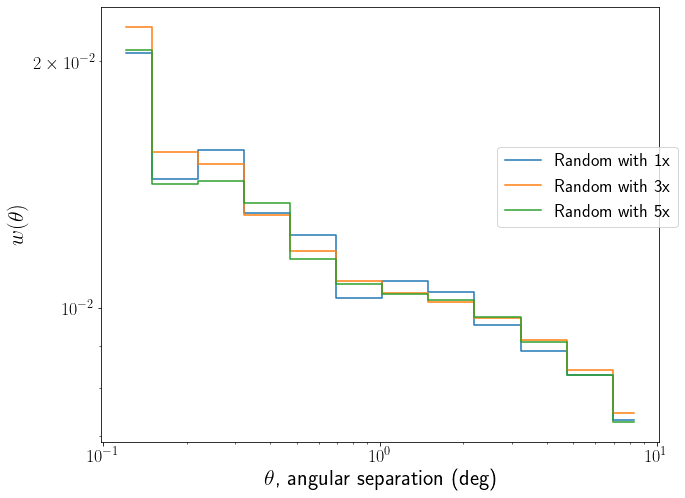

In [52]:
plt.figure(figsize=(10,8))
for i, fac_rand in enumerate(facs_rand):
    plt.step(theta_avg_log, wthetas_plane_facchecks_log[i], where='mid', label=f'Random with {fac_rand}x')
plt.xlabel(r'$\theta$, angular separation (deg)')
plt.ylabel(r'$w(\theta)$')
plt.xscale('log')
plt.yscale('log')
plt.axhline(0, color='grey', lw=0.8)
plt.legend(bbox_to_anchor=(1.05, 0.7))

Great - a low random factor just makes it noisier but the overall slope is the same, so we can use 1x to test slope-related things.

## Load in randoms

In [64]:
fac_rand = 1

### Completess only

In [65]:
tab_rcomp = utils.load_table(f'../data/randoms/random_completeness_{fac_rand}x.fits')

In [66]:
map_nqso_rcomp, pixel_indices_randcomp = utils.get_map(NSIDE, tab_rcomp['ra'], tab_rcomp['dec'], null_val=0)

0.0 180.0 -180.0 180.0


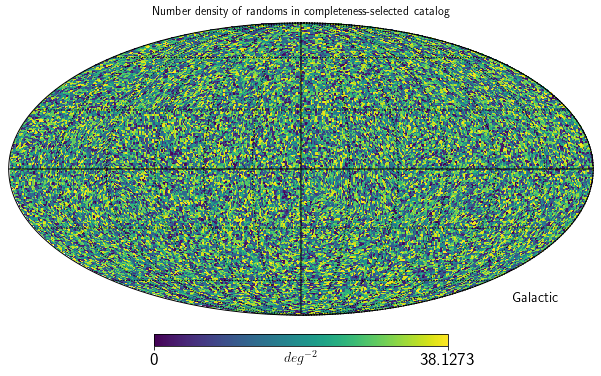

In [67]:
hp.mollview(
    map_nqso_rcomp/area_per_pixel,
    title=rf"Number density of randoms in completeness-selected catalog",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

### Completeness + dust

In [68]:
tab_rcompdust = utils.load_table(f'../data/randoms/random_dust_completeness_{fac_rand}x.fits')

In [69]:
map_nqso_rcompdust, pixel_indices_randcompdust = utils.get_map(NSIDE, tab_rcompdust['ra'], tab_rcompdust['dec'], 
                                                               null_val=0)

0.0 180.0 -180.0 180.0


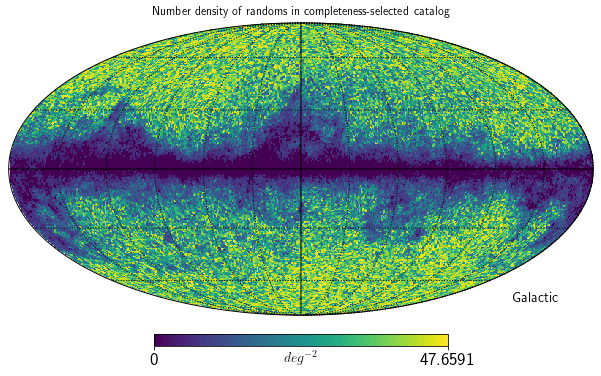

In [70]:
hp.mollview(
    map_nqso_rcompdust/area_per_pixel,
    title=rf"Number density of randoms in completeness-selected catalog",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

### Completeness + dust + mask galactic plane

In [83]:
tab_rcompdustplane = utils.load_table(f'../data/randoms/random_dust_completeness_maskplane_{fac_rand}x.fits')

In [84]:
map_nqso_rcompdustplane, _ = utils.get_map(NSIDE, tab_rcompdustplane['ra'], tab_rcompdustplane['dec'], null_val=0)

0.0 180.0 -180.0 180.0


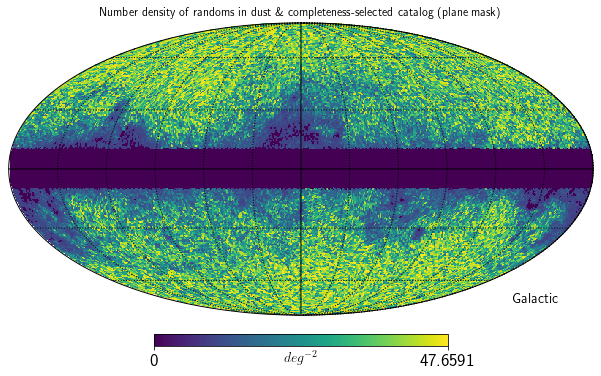

In [85]:
hp.mollview(
    map_nqso_rcompdustplane/area_per_pixel,
    title=rf"Number density of randoms in dust \& completeness-selected catalog (plane mask)",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

### Completeness + dust + mask galactic plane + mask MCs

In [97]:
tab_rcompdustplanemcs = utils.load_table(f'../data/randoms/random_dust_completeness_maskplane_maskmcs_{fac_rand}x.fits')

In [98]:
map_nqso_rcompdustplanemcs, _ = utils.get_map(NSIDE, tab_rcompdustplanemcs['ra'], tab_rcompdustplanemcs['dec'], 
                                              null_val=0)

0.0 180.0 -180.0 180.0


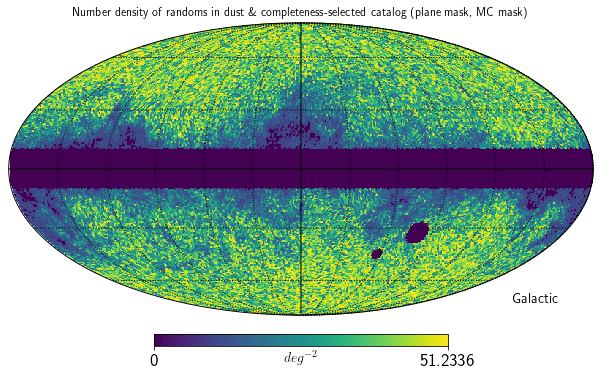

In [111]:
hp.mollview(
    map_nqso_rcompdustplanemcs/area_per_pixel,
    title=rf"Number density of randoms in dust \& completeness-selected catalog (plane mask, MC mask)",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

### Completeness + dust + mask galactic plane + mask MCs + mask dust

In [112]:
tab_rcompdustplanemcsAv = utils.load_table(f'../data/randoms/random_dust_completeness_maskplane_maskmcs_maskdust_{fac_rand}x.fits')

In [113]:
map_nqso_rcompdustplanemcsAv, _ = utils.get_map(NSIDE, tab_rcompdustplanemcsAv['ra'], tab_rcompdustplanemcsAv['dec'], 
                                              null_val=0)

0.0 180.0 -180.0 180.0


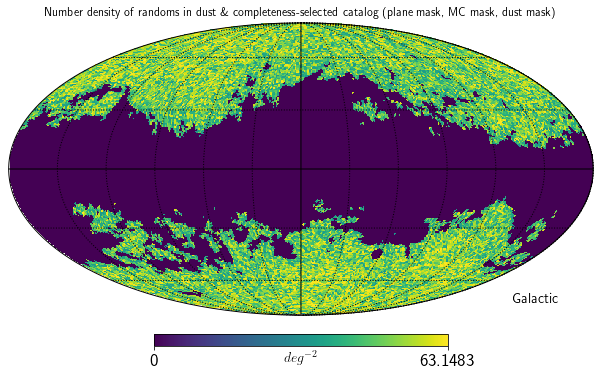

In [114]:
hp.mollview(
    map_nqso_rcompdustplanemcsAv/area_per_pixel,
    title=rf"Number density of randoms in dust \& completeness-selected catalog (plane mask, MC mask, dust mask)",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

## w(theta) for different randoms / masks

In [75]:
wtheta_rcomp_log = correlations.compute_wtheta(theta_edges_log, ra_data, dec_data,
                                                tab_rcomp['ra'], tab_rcomp['dec'])

/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/Corrfunc/utils.py:918: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


Time: 6.4391 s
Time: 10.6010 s
Time: 5.5570 s


In [77]:
wtheta_rcompdust_log = correlations.compute_wtheta(theta_edges_log, ra_data, dec_data,
                                                tab_rcompdust['ra'], tab_rcompdust['dec'])

Time: 6.5330 s
Time: 13.3991 s
Time: 6.8261 s


Where we mask things in the random, we must also do so in the data:

In [82]:
wtheta_rcompdustplane_log = correlations.compute_wtheta(theta_edges_log, ra_data_plane, dec_data_plane,
                                                tab_rcompdustplane['ra'], tab_rcompdustplane['dec'])

Time: 6.2549 s
Time: 12.8299 s
Time: 6.6270 s


In [100]:
wtheta_rcompdustplanemcs_log = correlations.compute_wtheta(theta_edges_log, ra_data_planemcs, dec_data_planemcs,
                                                tab_rcompdustplanemcs['ra'], tab_rcompdustplanemcs['dec'])

/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/Corrfunc/utils.py:918: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


Time: 6.3954 s
Time: 13.1084 s
Time: 6.7223 s


In [130]:
wtheta_rcompdustplanemcsAv_log = correlations.compute_wtheta(theta_edges_log, ra_data_planemcsAv, dec_data_planemcsAv,
                                                tab_rcompdustplanemcsAv['ra'], tab_rcompdustplanemcsAv['dec'])

/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/Corrfunc/utils.py:918: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


Time: 4.7101 s
Time: 13.6757 s
Time: 10.0367 s


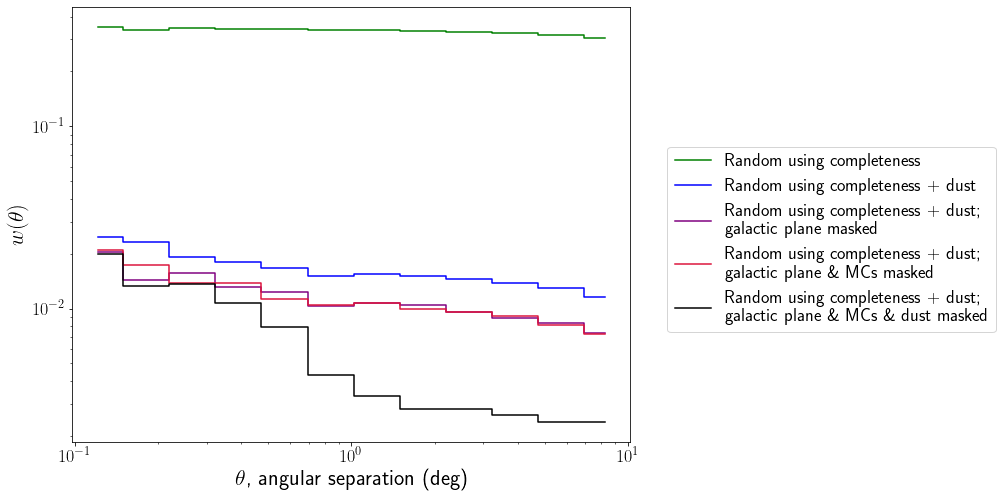

In [131]:
plt.figure(figsize=(10,8))
plt.step(theta_avg_log, wtheta_rcomp_log, where='mid', color='green',
         label=f'Random using completeness')
plt.step(theta_avg_log, wtheta_rcompdust_log, where='mid', color='blue',
         label=f'Random using completeness + dust')
plt.step(theta_avg_log, wtheta_rcompdustplane_log, where='mid', color='purple',
         label=f'Random using completeness + dust;\n galactic plane masked')
plt.step(theta_avg_log, wtheta_rcompdustplanemcs_log, where='mid', color='crimson',
         label=f'Random using completeness + dust;\n galactic plane \& MCs masked')
plt.step(theta_avg_log, wtheta_rcompdustplanemcsAv_log, where='mid', color='black',
         label=f'Random using completeness + dust;\n galactic plane \& MCs \& dust masked')
plt.xlabel(r'$\theta$, angular separation (deg)')
plt.ylabel(r'$w(\theta)$')
plt.xscale('log')
plt.yscale('log')
plt.axhline(0, color='grey', lw=0.8)
plt.legend(bbox_to_anchor=(1.05, 0.7))